#### GAN to Generate Fake MNIST Digits
We'll build:

A Generator: takes random noise and creates fake images

A Discriminator: tries to tell real from fake images

A combined GAN model: trains the generator to fool the discriminator

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist


### Build the Generator

In [8]:
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(Dense(784, activation='tanh'))  # Output size = 28x28 = 784
    model.add(Reshape((28, 28, 1)))
    return model


### Build the Discriminator

In [9]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output: real/fake
    return model


### Compile the Models

In [10]:
# Create models
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Combined GAN model (freeze discriminator while training generator)
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
validity = discriminator(generated_image)
gan = tf.keras.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')


C:\Users\pavan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\pavan\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train the GAN

In [12]:
# Load and preprocess MNIST
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension

batch_size = 64
epochs = 1000
half_batch = batch_size // 2

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_images = X_train[idx]
    
    noise = np.random.normal(0, 1, (half_batch, 100))
    fake_images = generator.predict(noise)
    
    d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator (via GAN)
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.ones((batch_size, 1))  # Generator wants discriminator to think fakes are real
    g_loss = gan.train_on_batch(noise, valid_y)

    # Print progress
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0 [D loss: 5.6254, acc: 0.83%] [G loss: 0.0037]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9

### Visualize Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


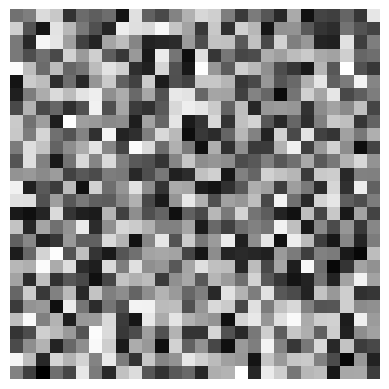

In [13]:
import matplotlib.pyplot as plt

def show_generated_image(generator):
    noise = np.random.normal(0, 1, (1, 100))
    gen_image = generator.predict(noise)[0, :, :, 0]
    plt.imshow(gen_image, cmap='gray')
    plt.axis('off')
    plt.show()

show_generated_image(generator)


In [ ]:
#!pip install tensorflow